<a href="https://colab.research.google.com/github/maheenna/chatbot_with_tavily_and_memory/blob/main/Chatbot_with_tavily_and_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Chatbot Without Web Search Access and Memory


In [1]:
!pip install -q -U langgraph langchain_community langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.2,
    api_key=gemini_api_key
)

In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
  message:str


In [ ]:
from langgraph.graph import START , END , StateGraph

def chatbot(state:State):
  return {"message":[llm.invoke(state["message"])]}

graph_builder = StateGraph(State)
# add node - pass the node name first, followed by the function
graph_builder.add_node("Chatbot", chatbot)

# add edges
graph_builder.add_edge(START ,"Chatbot")
graph_builder.add_edge("Chatbot" , END)
graph = graph_builder.compile()

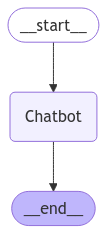

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def stream_graph_updates(user_input:str):
    for event in graph.stream({"message": [("user", user_input)]}):
      for value in event.values():
        print("Assistant: ", value["message"][-1].content)

user_input = "Hi my name is Maheen"
stream_graph_updates(user_input)

Assistant:  Hi Maheen, it's nice to meet you!  How can I help you today?



In [ ]:
def stream_graph_updates(user_input:str):
    for event in graph.stream({"message": [("user", user_input)]}):
      for value in event.values():
        print("Assistant: ", value["message"][-1].content)

user_input = "what is my name and what is date today?"
stream_graph_updates(user_input)

Assistant:  I do not know your name.  I have no access to personal information about you.

Today's date is October 26, 2023.



At this point the chatbot does not have web search and memory


# Tavily: Web Search Tool

In [5]:
!pip install -q -U tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.9 MB/s eta 0:00:00


In [6]:
import os
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what a node in langgraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making decisions, or interacting with external APIs.'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed.'}]

 **at this point we have made a tool of web search Now integrate this tool in chatbot **

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# this class add messages in a list
class State(TypedDict):
  messages: Annotated[list , add_messages]

In [12]:
from langgraph.graph import START , END , StateGraph
from langgraph.prebuilt import ToolNode , tools_condition
llm_with_tool = llm.bind_tools(tools)

def chatbot(state:State):
  return {"messages": llm_with_tool.invoke(state["messages"])}

def simple_tool_handler(user_input):
    tool_response = tool.invoke(user_input)
    return tool_response or "No tool response available."

graph_builder = StateGraph(State)
graph_builder.add_node("Chatbot", chatbot)

graph_builder.add_node("Tools", simple_tool_handler)

graph_builder.add_edge(START , "Chatbot")
graph_builder.add_conditional_edges(
    "Chatbot",
    tools_condition
)
graph_builder.add_edge("Tools", "Chatbot")
graph = graph_builder.compile()

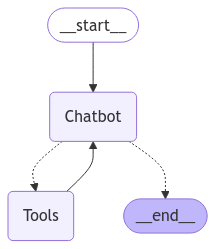

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def process_input(user_input: str):
    """
    Process the user input and get a response from either Tavily tool or LLM.
    """
    try:
        # Step 1: Try Tavily tool first
        tool_response = tool.invoke(user_input)
        if tool_response:
            print("Assistant (Tavily):", tool_response)
            return

        # Step 2: If Tavily fails, fallback to LLM
        llm_response = llm.invoke([("user", user_input)])
        if llm_response and isinstance(llm_response, list) and llm_response[0]:
            print("Assistant (LLM):", llm_response[0]["content"])
            return

        # Step 3: If everything fails
        print("Assistant: Sorry, I could not process your request.")
    except Exception as e:
        print("Error:", e)
        print("Assistant: An error occurred while processing your request.")

# Single input from user
user_input = "what is weather in karachi?"
process_input(user_input)


Assistant (Tavily): [{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1733147398, 'localtime': '2024-12-02 18:49'}, 'current': {'last_updated_epoch': 1733147100, 'last_updated': '2024-12-02 18:45', 'temp_c': 27.2, 'temp_f': 81.0, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png', 'code': 1030}, 'wind_mph': 10.3, 'wind_kph': 16.6, 'wind_degree': 280, 'wind_dir': 'W', 'pressure_mb': 1011.0, 'pressure_in': 29.85, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 28, 'cloud': 0, 'feelslike_c': 27.7, 'feelslike_f': 81.8, 'windchill_c': 25.9, 'windchill_f': 78.7, 'heatindex_c': 26.5, 'heatindex_f': 79.6, 'dewpoint_c': 14.0, 'dewpoint_f': 57.3, 'vis_km': 4.0, 'vis_miles': 2.0, 'uv': 0.0, 'gust_mph': 15.4, 'gust_kph': 24.8}}"}, {'url': 'https://world-weather.info/forecast/pakistan/karachi/februar

now at that point chatbot has the functionality of  **Web Search **

# **Add memory in chatbot**

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [ ]:
from langgraph.graph import START , END , StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain.tools.tavily_search import TavilySearchResults

class State(TypedDict):
  messages: Annotated[list , add_messages]

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tool = llm.bind_tools(tools)

def chatbot(state:State):
  return {"messages": llm_with_tool.invoke(state["messages"])}

def simple_tool_handler(user_input):
    tool_response = tool.invoke(user_input)
    return tool_response or "No tool response available."

graph_builder = StateGraph(State)
graph_builder.add_node("Chatbot", chatbot)
graph_builder.add_node("Tools", simple_tool_handler)

graph_builder.add_edge(START , "Chatbot")
graph_builder.add_conditional_edges(
    "Chatbot",
    tools_condition
)
graph_builder.add_edge("Tools", "Chatbot")

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

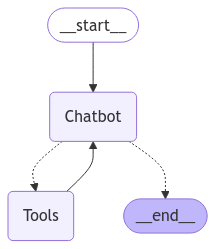

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable":{"thread_id":1}}

In [ ]:
user_input = "Hi, there my name is Maheen."
events = graph.stream(
    {"messages":[("user",user_input)]},config , stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, there my name is Maheen.
================================== Ai Message ==================================

Hi Maheen, it's nice to meet you! How can I help you today?


In [ ]:
user_input = "what is my name?"
events = graph.stream(
    {"messages":[("user",user_input)]},config , stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

Your name is Maheen.
